<a href="https://colab.research.google.com/github/tangYang7/GAI/blob/main/exercise/week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Import Parkage and Running setting

In [145]:
!pip install gradio

In [146]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# for interactive design
from ipywidgets import interact_manual

# Gradio for creating web apps quickly
import gradio as gr

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

## 1. Read MNIST Corpus

In [147]:
trainset=torchvision.datasets.MNIST(root='./data',train=True,download=True,transform=torchvision.transforms.ToTensor())
testset=torchvision.datasets.MNIST(root='./data',train=False,download=True,transform=torchvision.transforms.ToTensor())

### The training set has 60,000 samples, whereas the test set has 10,000.

In [148]:
print(f'訓練資料總筆數為 {len(trainset)} 筆資料')
print(f'測試資料總筆數為 {len(testset)} 筆資料')

訓練資料總筆數為 60000 筆資料
測試資料總筆數為 10000 筆資料


In [149]:
def dataset_get_xy(input_dataset):
    x = torch.stack([image.squeeze(0) for image, _ in input_dataset])
    y = torch.tensor([label for _, label in input_dataset])
    return x, y

train_x, train_y = dataset_get_xy(trainset)
test_x, test_y = dataset_get_xy(testset)

In [150]:
def show_xy(n=0):
  ax = plt.gca()
  X = train_x[0]
  plt.xticks([], [])
  plt.yticks([], [])
  plt.imshow(X, cmap = 'Greys')
  print(f'本資料 y 給定的答案為: {train_y[0]}')

In [151]:
interact_manual(show_xy, n=(0,59999));

interactive(children=(IntSlider(value=0, description='n', max=59999), Button(description='Run Interact', style…

In [152]:
def show_data(n = 100):
  X = train_x[0]
  print(X)

In [153]:
interact_manual(show_data, n=(0,59999));

interactive(children=(IntSlider(value=100, description='n', max=59999), Button(description='Run Interact', sty…

In [154]:
train_x = train_x.reshape(train_x.shape[0], -1)
test_x = test_x.reshape(test_x.shape[0], -1)

### The label is a number. For training, we convert it into representation of one-hot encoding

In [155]:
n = 87
train_y[n]

tensor(9)

In [156]:
train_y = F.one_hot(train_y, num_classes=10)
test_y = F.one_hot(test_y, num_classes=10)

In [157]:
train_y[n]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

## 3. Build a network model

我們決定了我們的函數是

$$\hat{f} \colon \mathbb{R}^{784} \to \mathbb{R}^{10}$$

這個樣子。而我們又說第一次要用標準神網路試試, 所以我們只需要再決定要幾個隱藏層、每層要幾個神經元, 用哪個激發函數就可以了。

In [158]:
Model_config = {
  "N1_dim": 20,
  "N2_dim": 30,
  "N3_dim": 30,
  "N4_dim": 20,
  "input_dim": train_x.shape[1],
  "output_dim": 10,
}

In [159]:
class DNN_Classifier(nn.Module):
    def __init__(self, config):
        super(DNN_Classifier, self).__init__()
        self.fc1 = nn.Linear(784, config["N1_dim"])
        self.fc2 = nn.Linear(config["N1_dim"], config["N2_dim"])
        self.fc3 = nn.Linear(config["N2_dim"], config["N3_dim"])
        self.fc4 = nn.Linear(config["N3_dim"], config["N4_dim"])
        self.fc5 = nn.Linear(config["N4_dim"], config["output_dim"])

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

    def decoding(self, x):
        logit = F.softmax(x, dim=1)
        pred = torch.argmax(logit, dim=1)
        return logit, pred

In [160]:
model = DNN_Classifier(config=Model_config)
model

DNN_Classifier(
  (fc1): Linear(in_features=784, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=30, bias=True)
  (fc4): Linear(in_features=30, out_features=20, bias=True)
  (fc5): Linear(in_features=20, out_features=10, bias=True)
)

In [161]:
training_config = {
  "batch_size": 100,
  "epoch": 100,
  "learning_rate": 0.01,

}
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=training_config["learning_rate"])

In [162]:
# prompt: training
losses = []
for epoch in range(training_config["epoch"]):
  epoch_loss = 0
  for i in range(0, len(train_x), training_config["batch_size"]):
    x = train_x[i:i+training_config["batch_size"]]
    y = train_y[i:i+training_config["batch_size"]]
    optimizer.zero_grad()
    y_hat = model(x.float())
    loss = criterion(y_hat, y.float())
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
  losses.append(epoch_loss)
  if epoch % 10 == 0:
    print(f"Epoch {epoch+1}/{training_config['epoch']}, Loss: {epoch_loss:.4f}")

Epoch 1/100, Loss: 1381.2278
Epoch 2/100, Loss: 1373.0972
Epoch 3/100, Loss: 1338.0714
Epoch 4/100, Loss: 1088.6995
Epoch 5/100, Loss: 626.9109
Epoch 6/100, Loss: 447.6346
Epoch 7/100, Loss: 378.1988
Epoch 8/100, Loss: 326.9029
Epoch 9/100, Loss: 283.9244
Epoch 10/100, Loss: 252.4680
Epoch 11/100, Loss: 231.4861
Epoch 12/100, Loss: 215.9544
Epoch 13/100, Loss: 203.0535
Epoch 14/100, Loss: 192.1099
Epoch 15/100, Loss: 182.6365
Epoch 16/100, Loss: 173.9516
Epoch 17/100, Loss: 165.9218
Epoch 18/100, Loss: 158.4640
Epoch 19/100, Loss: 151.5518
Epoch 20/100, Loss: 145.3034
Epoch 21/100, Loss: 139.6863
Epoch 22/100, Loss: 134.6785
Epoch 23/100, Loss: 130.1952
Epoch 24/100, Loss: 126.1290
Epoch 25/100, Loss: 122.4621
Epoch 26/100, Loss: 119.0598
Epoch 27/100, Loss: 115.8675
Epoch 28/100, Loss: 112.8947
Epoch 29/100, Loss: 110.0923
Epoch 30/100, Loss: 107.4675
Epoch 31/100, Loss: 105.0569
Epoch 32/100, Loss: 102.8166
Epoch 33/100, Loss: 100.6923
Epoch 34/100, Loss: 98.6244
Epoch 35/100, Loss: 

In [163]:
pred = []
with torch.no_grad():
  test_x = test_x.float()
  y_hat = model(test_x)
  loss = criterion(y_hat, torch.argmax(test_y.float(), dim=1))

  _, predicted = model.decoding(y_hat)
  pred.append(predicted)
  pred = torch.cat(pred, dim=0)
  print(len(pred))
  correct = (predicted == torch.argmax(test_y, dim=1)).sum().item()
  accuracy = correct / len(test_x)
  print(f"Test Loss: {loss:.4f}")
  print(f"Test Accuracy: {accuracy * 100:.4f}%")

10000
Test Loss: 0.1676
Test Accuracy: 95.5000%


In [164]:
print(len(pred))

10000


In [165]:
def test(test_id):
    plt.imshow(test_x[test_id].reshape(28,28), cmap='Greys')
    print('神經網路判斷為:', pred[test_id].item())

In [166]:
interact_manual(test, test_id=(0, 9999));

interactive(children=(IntSlider(value=4999, description='test_id', max=9999), Button(description='Run Interact…

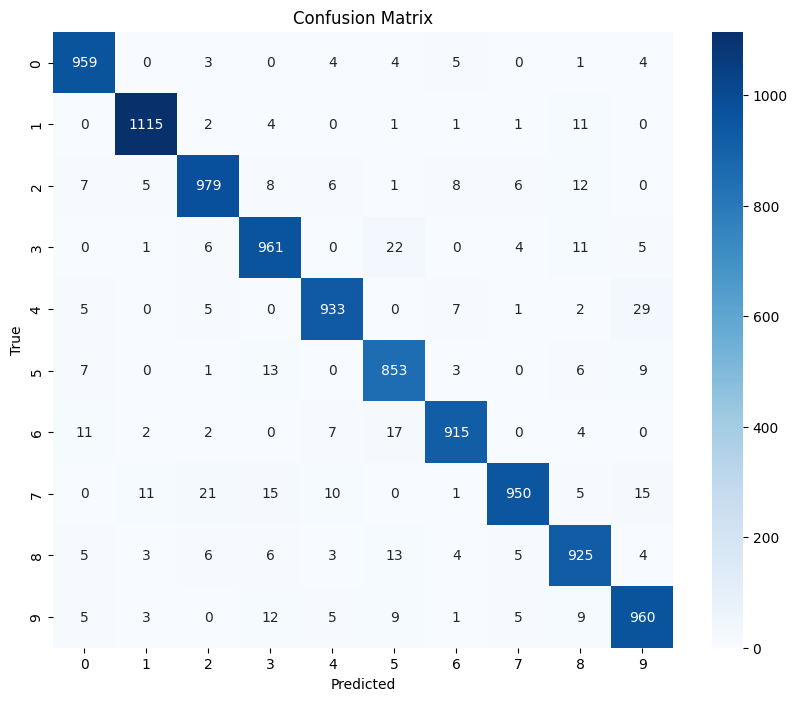

In [167]:
# prompt: draw confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming 'pred' contains your model's predictions and 'test_y' contains the true labels
# Convert tensors to numpy arrays if necessary
pred_np = pred.numpy()
true_labels_np = torch.argmax(test_y, dim=1).numpy()

cm = confusion_matrix(true_labels_np, pred_np)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
